## StationSim Validation Using Ripley's K

The aim of this notebook is to establish whether the outputs of two different versions of our agent based model (ABM) StationSim in python and c++ produce the same output. Since our model is by nature highly stochastic and non-linear it is difficult to do this without seeding each model. 

The aim of this notebook is to generate two populations of StationSim models without any seeding and test statistically if there is any evidence the two groups produce distinct results. We do this by analysing the `collision_history_loc` attribute for each stationsim instance telling us where any collisions between two agents occured in the model. We calculate the Ripley's K (RK) trajectories for each set of collisions giving two samples of RK curves.

Using these two populations of curves, we fit a panel regression in R. and test if there is a different between the two groups using a backwards stepwise regression, ANOVA, and comparison of Aikake's Information Criterion (AIC).

This notebook will demonstrate how we calculate RK curves from a set of models and compile them into a dataframe to be used in R.

In [11]:
"Make sure all imports work before running this notebook further."
from stationsim_model import Model #python version of stationsim
from stationsim_validation import stationsim_RipleysK
ssRK = stationsim_RipleysK()

## Building a Population of StationSim Models and Asessing the Clustering

First we define the StationSim model we wish to test. StationSim requires a dictionary of input parameters which we define below. We are particularly interested in the model width, height, population total, and rate at which agents enter model `gates_speed`.

Using these parameters we run a set of models using `ssRK.generate_model_sample`. The size of the sample is determined by `n_test_runs`. We currently are only getting 1 model per batch for plotting purposes. Note we are seeding this time using the `random_seed` arguement for demonstrative purposes. We will not seed any runs outside of this notebook.

In [2]:
model_params = {
'width': 200,
'height': 50,
'pop_total': 10,
'gates_speed': 1,

'gates_in': 3,
'gates_out': 2,
'gates_space': 1,

'speed_min': .2,
'speed_mean': 1,
'speed_std': 1,
'speed_steps': 3,

'separation': 5,
'max_wiggle': 1,

'step_limit': 3600,

'do_history': True,
'do_print': True,
    
'random_seed' : 8,
}

n_test_runs = 1

model1 = ssRK.generate_model_sample(n_test_runs, model_params)
model_params["random_seed"] = 2 #change seed
model2 = ssRK.generate_model_sample(n_test_runs, model_params)


## Clustering Analysis

We can easily plot where the collisions happen in a model using a kernel density estimate (KDE). We have chosen a low number of agents (10) to demonstrate the extreme cases of how collisions can vary.

For our first model we notice most of the collisions occur in a straight line fashion across the map. This demonstrates a clear sign of queueing where some agent(s) are stuck behind and constantly colliding with a slower agent. Note we also have very few collisions near the entrance gates, suggesting all agents enter at different times with little difficulty.

Our second plot shows three large groups of collisions near the entrance gates. It is clear that all our agents enter the model at a similar time causing large initial crowding. As time progesses the agents break away and proceed unhindered with no futher collisions.

We have the two extreme cases of collision clustering here. The first case shows collisions that are quite widely dispersed across the map whereas the second model has very tightly clustered collisions.

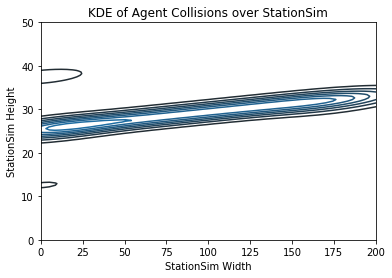

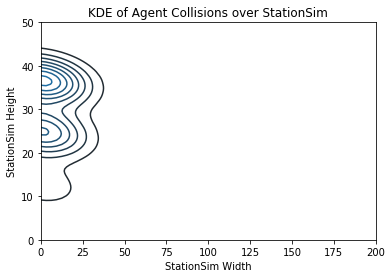

In [3]:
ssRK.collisions_kde(model1[0])
ssRK.collisions_kde(model2[0])

## Ripley's K analysis of Collisions

Ripley's K is used as a measure of how dispersed some set of points is throughout a region of interest. I refer the 
reader to the more detailed link below.
 
(https://wiki.landscapetoolbox.org/doku.php/spatial_analysis_methods:ripley_s_k_and_pair_correlation_function)

We can visualise the distribution of collisions using Ripley's K curves. Generally, if our agents are tightly clustered tightly we see a rapid increase in RK score that quickly plateaus. Conversely, if our collisions are spread out we see a slow linear increase in the RK score.

We plot RK curves for the clustered and dispersed models below clearly seeing these characteristics. We expect an envelope* such that almost all RK curves lie within these extremes.

(*The theoretical maximum RK score is a vertical line from (0,0) where all collisions occur at exactly the same point. The minimum score would be a straight line where all collisions are equally dispersed. Both these theoretical extremes are impossible in practice and make poor bounds so I use this much narrower boundary where there is a strong chance for outliers.)

100.0% complete                  

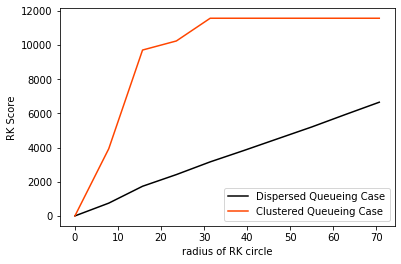

In [4]:
RKs1 = ssRK.generate_Test_Frame(model1)
RKs2 = ssRK.generate_Test_Frame(model2)
ssRK.notebook_RK_Plot(RKs1,RKs2)

To demonstrate this further we generate an unseeded larger sample of 100 StationSims with 10 agents to see the spread of these curves. It is clear the linear lower bound is much more defined than the upper bound.

100.0% complete                               

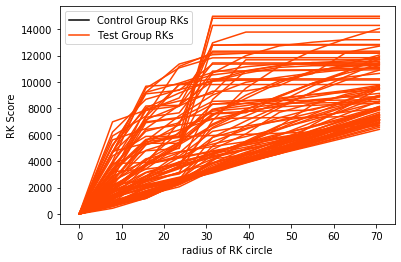

In [5]:
model_params["random_seed"] = None
n_test_runs = 100
models = ssRK.generate_model_sample(n_test_runs, model_params)
RKs = ssRK.generate_Test_Frame(models)
ssRK.spaghetti_RK_Plot(RKs)

Until now we have used a small number of agents (10) per model run. If we increases this we see the envelope of RK curves collapses quite dramatically. We get very few clustered cases as with `model2` above as the number and spread of collisions increases. We see that the results much more uniform regardless of seeding.

100.0% complete                              

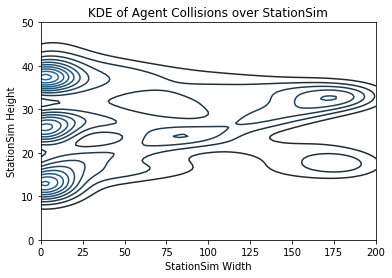

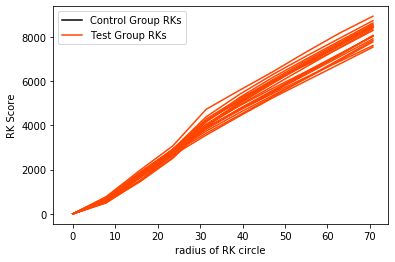

In [6]:
model_params["pop_total"] = 50
n_test_runs = 20
models = ssRK.generate_model_sample(n_test_runs, model_params)
ssRK.collisions_kde(models[0])
RKs = ssRK.generate_Test_Frame(models)
ssRK.spaghetti_RK_Plot(RKs)

## Testing Two Groups of StationSim Models

We have now defined the behaviour of RK curves on StationSim. We now present how we use these curves for testing. I will talk through the `main` file of `stationsim_RipleysK` and how it constructs a data frame ready for analysis in R. 

The function is broken into two parts, generating the control and test frames respectively. The first section generates the control frame. This generates a population of stationsim models from the python version, calculates the corresponding family of RK curves, and saves these curves in a pandas DataFrame.

First we generate a file name based on the given stationsim parameters. We look to see if control data already exists in the `RK_csvs` folder and if it does not, we generate a control group using 100 stationsim models with the provided parameters. This can take a long time for large ABM populations.
```
width = model_params["width"]
height = model_params["height"]
pop_total = model_params["pop_total"]
gates_speed = model_params["gates_speed"]

f_name = "RK_csvs/control_" + f"{width}_{height}_{pop_total}_{gates_speed}" + ".csv"

"try loading said file. if no file make and save one."
try:
    data_control = self.load_Frame(f_name)
    print("Control data found at: " + f_name)
except:
    print("No control frame found for given parameters.")
    print("Generating control frame using large number of models (100).")
    print("This may take a while if you have a large population of agents")
    control_models = ssRK.generate_model_sample(100, model_params)
    data_control = self.generate_Control_Frame(control_models)~~
    
```

The second section of the main function generates a test data frame. This takes models `test_models` from some new source, such as c++ stationsim, calculate the RK curves, and creates a dataframe for the test RK curves.

```
data_test = self.generate_Test_Frame(test_models)
```

Finally we concatenate the control and test group frames together and save this as a .csv for analysis by R.

```
data = pd.concat([data_control, data_test])
f_name = "RK_csvs/joint_" + f"{width}_{height}_{pop_total}_{gates_speed}"
f_name += ".csv"
self.save_Frame(data, f_name)
```

We provide an example usage where we have a test group of 50 python stationsim models each with a population of 30. We also provide another spaghetti plot using two groups this time for comparison.

Control data found at: RK_csvs/control_200_50_30_1.csv
100.0% complete                              

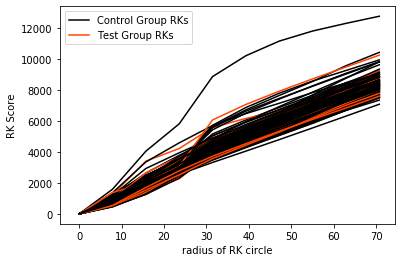

In [13]:
model_params = {
'width': 200,
'height': 50,
'pop_total': 30,
'gates_speed': 1,

'gates_in': 3,
'gates_out': 2,
'gates_space': 1,

'speed_min': .2,
'speed_mean': 1,
'speed_std': 1,
'speed_steps': 3,

'separation': 5,
'max_wiggle': 1,

'step_limit': 3600,

'do_history': True,
'do_print': True,
}

n_test_runs = 20
test_models = ssRK.generate_model_sample(n_test_runs, model_params)
data = ssRK.main(test_models, model_params)
ssRK.spaghetti_RK_Plot(data)